small d_hidden, don't expect a good fit!
[4, 32, 1]


----- running epoch 0:   0%|          | 0/6 [00:00<?, ?it/s]

not updating weights in first and last epoch


----- saving epoch 0:   0%|          | 0/6 [00:35<?, ?it/s] 

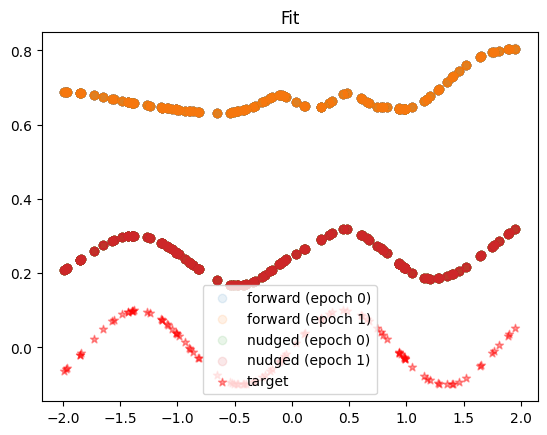

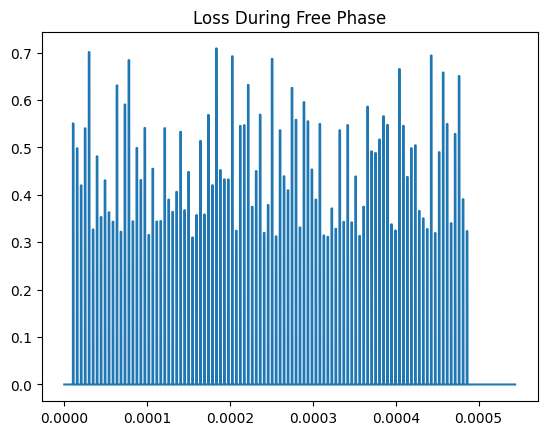

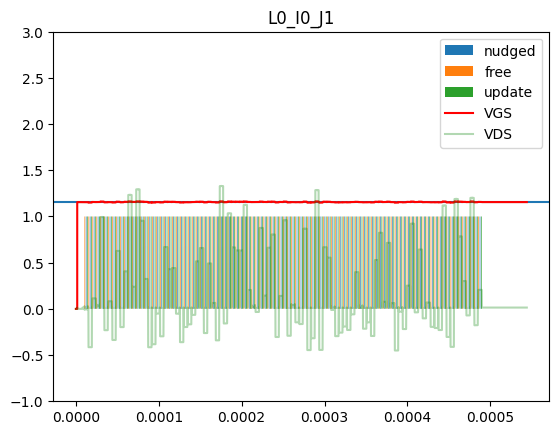

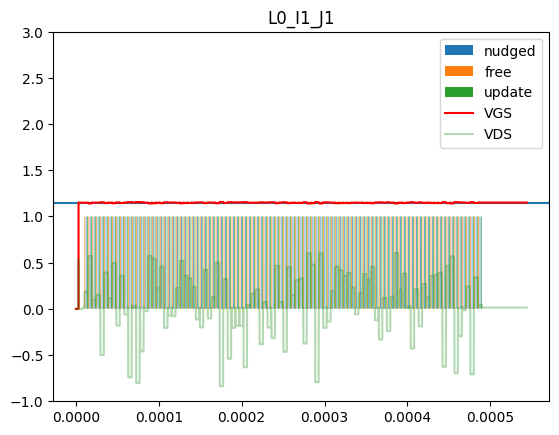

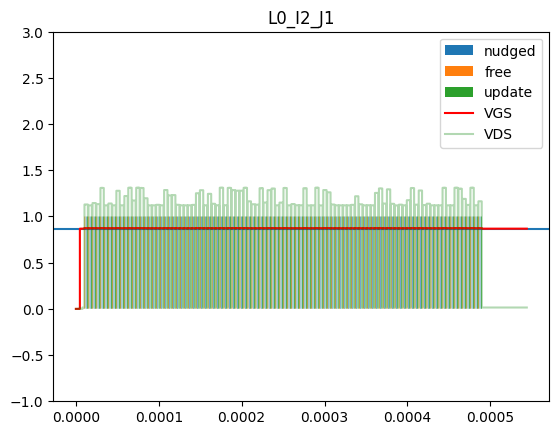

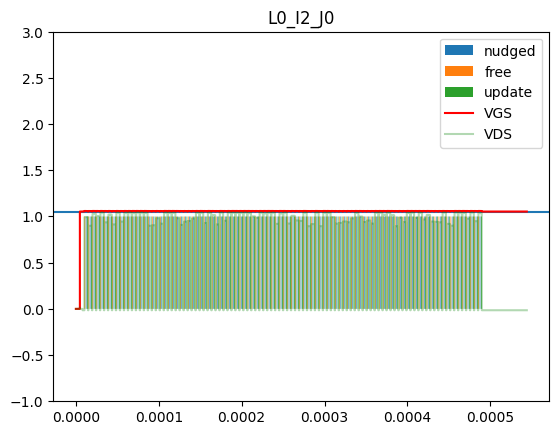

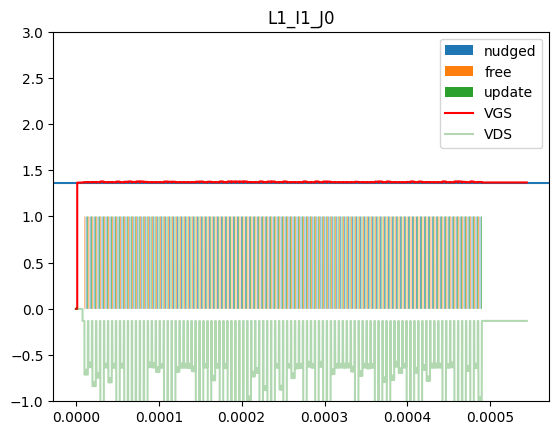

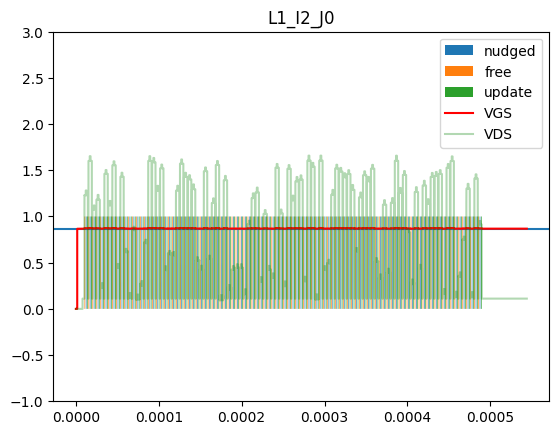

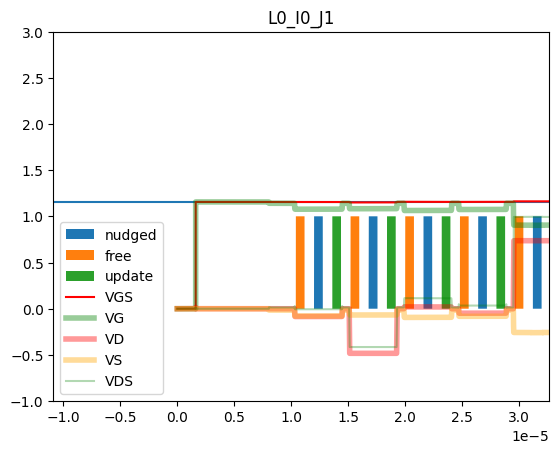

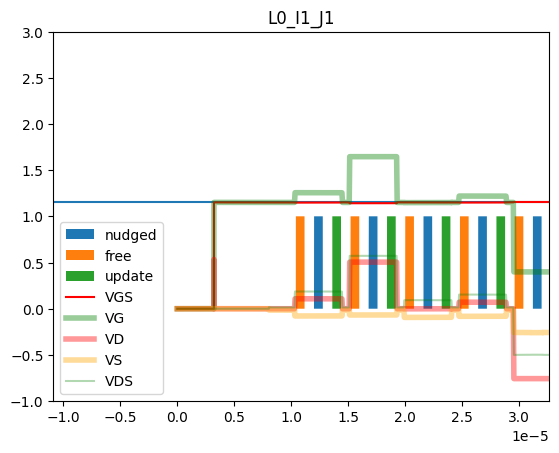

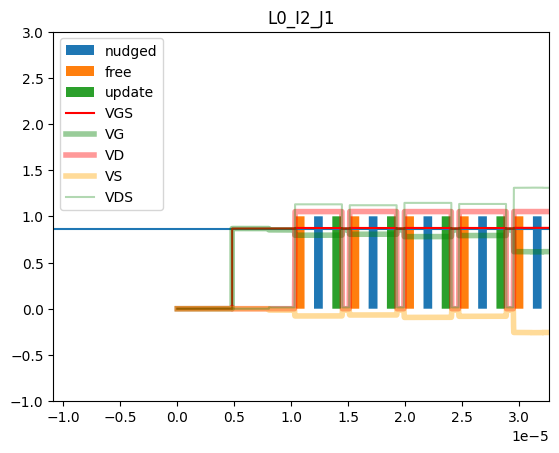

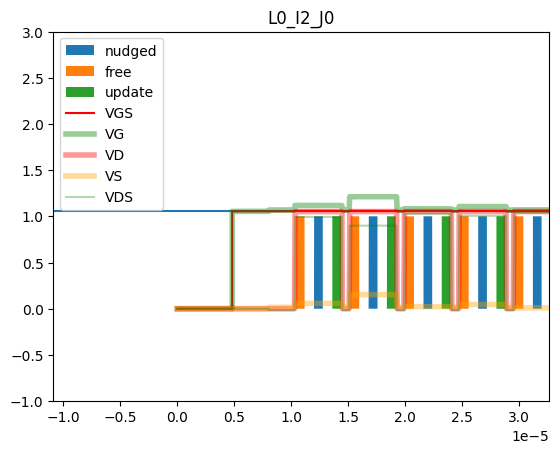

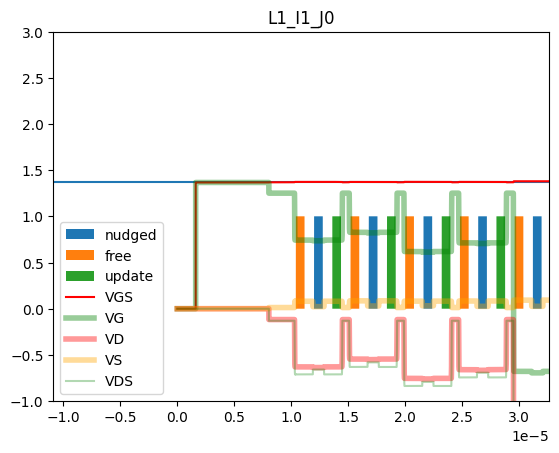

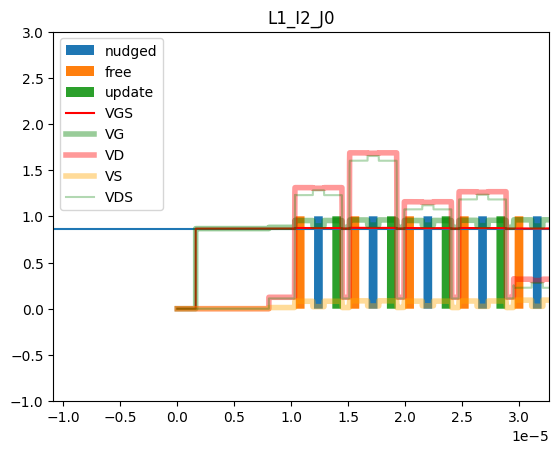

----- saving epoch 1:  17%|█▋        | 1/6 [01:36<03:04, 36.86s/it] 

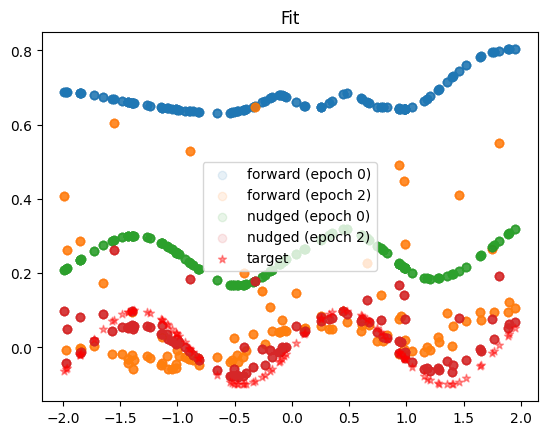

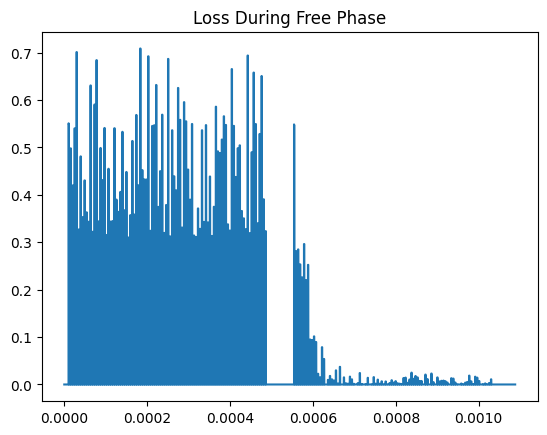

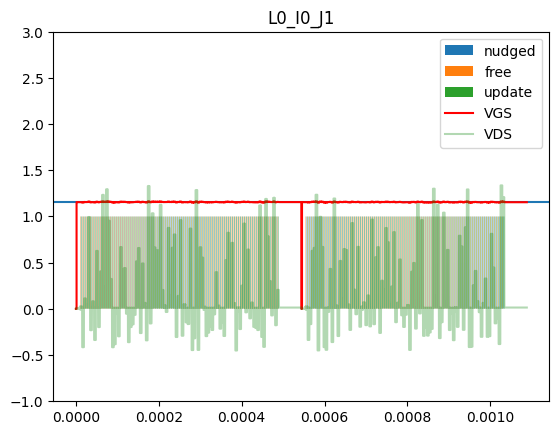

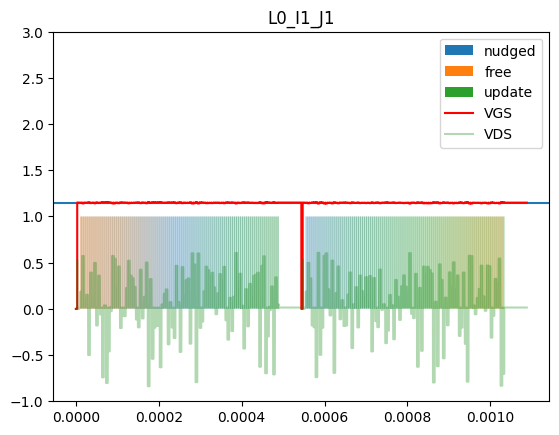

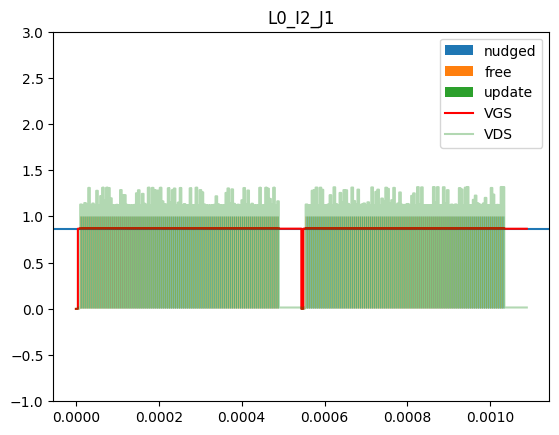

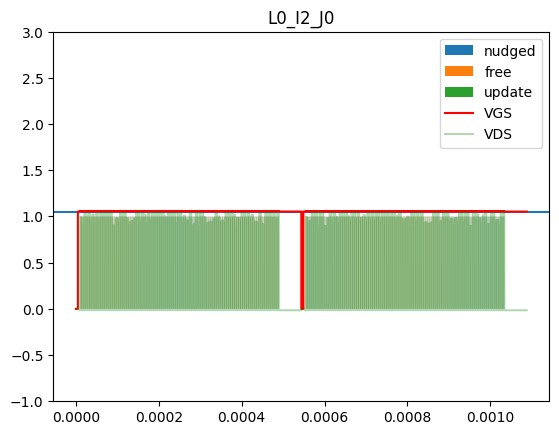

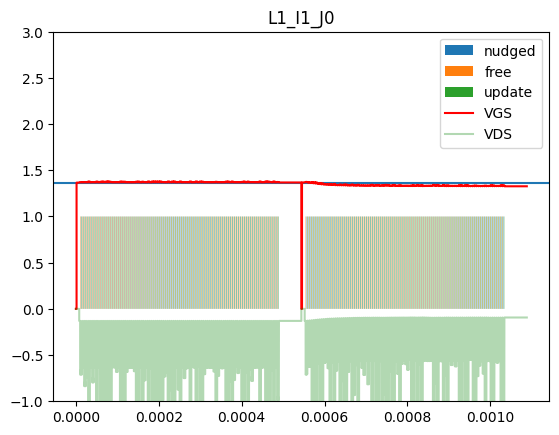

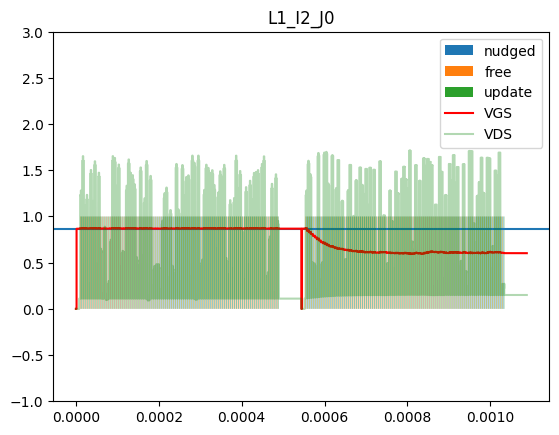

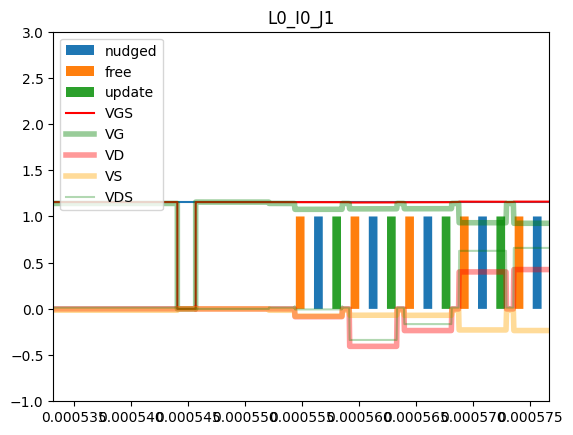

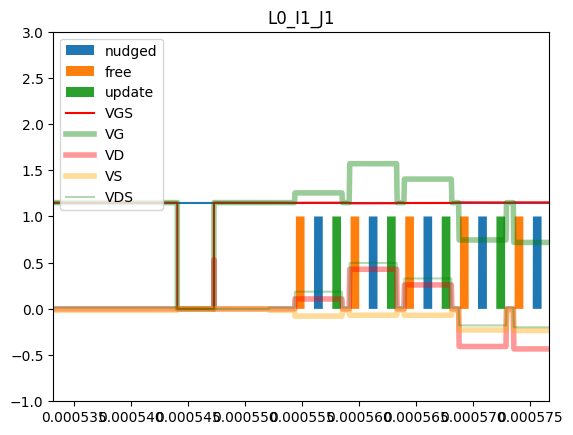

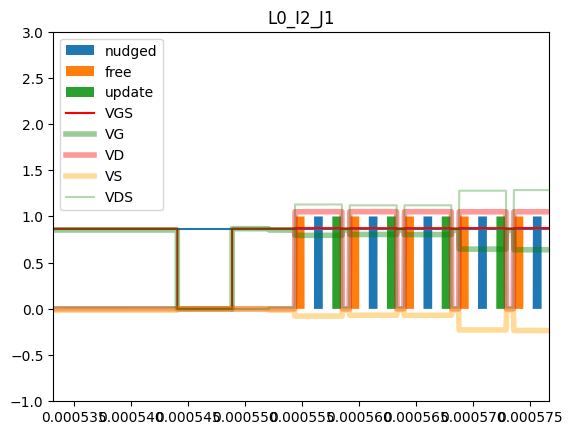

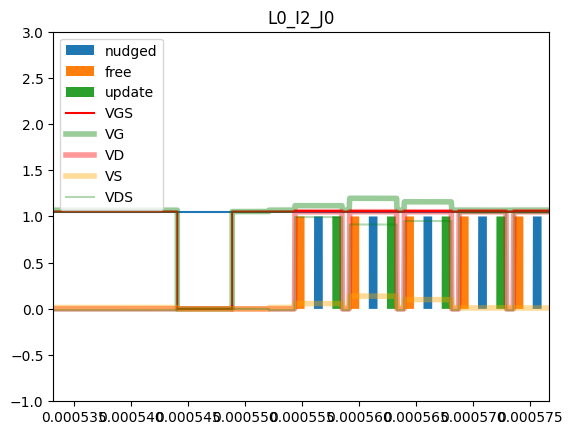

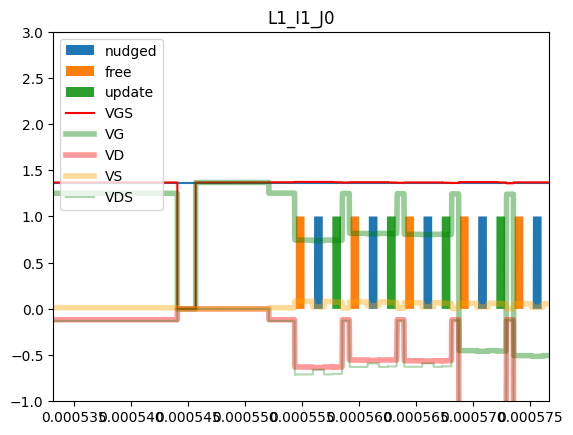

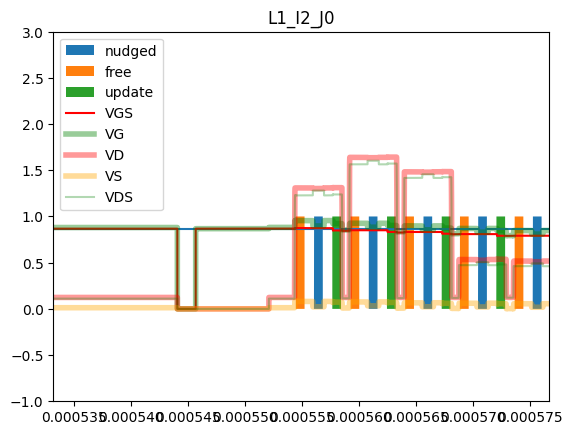

----- saving epoch 2:  33%|███▎      | 2/6 [02:38<03:29, 52.36s/it] 

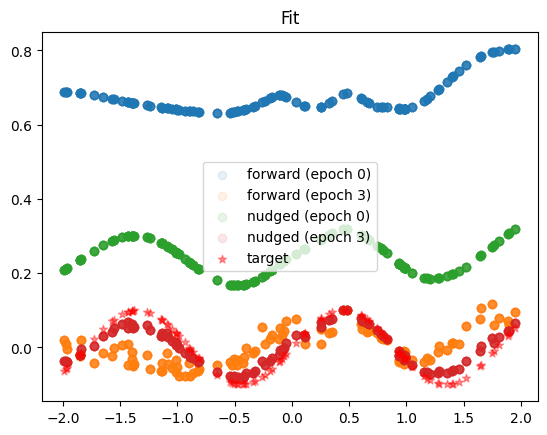

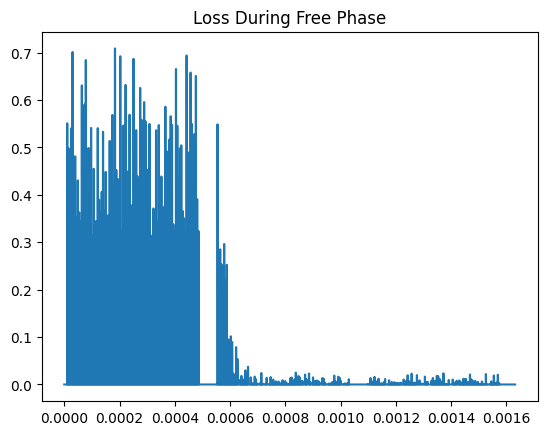

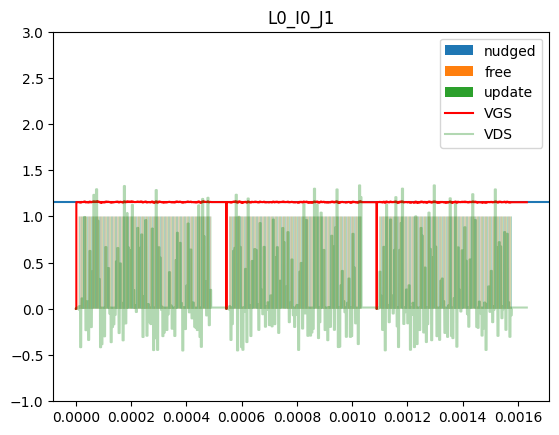

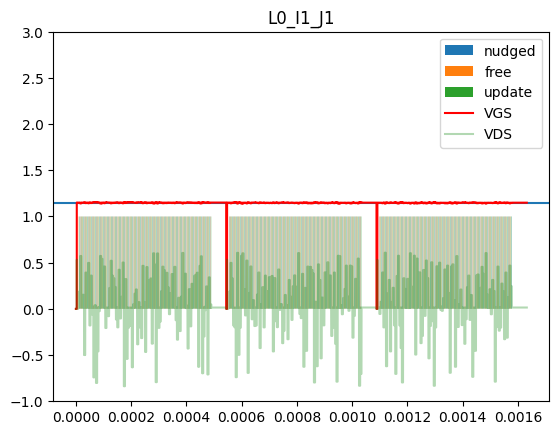

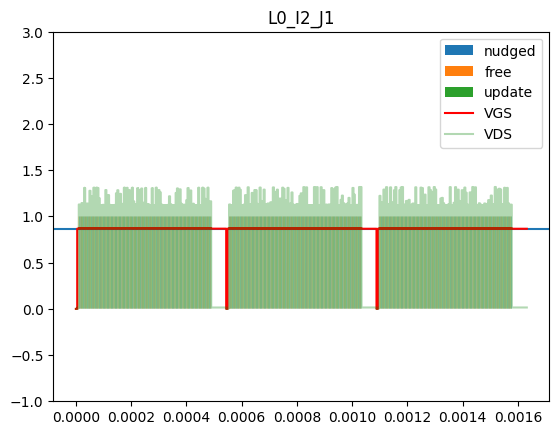

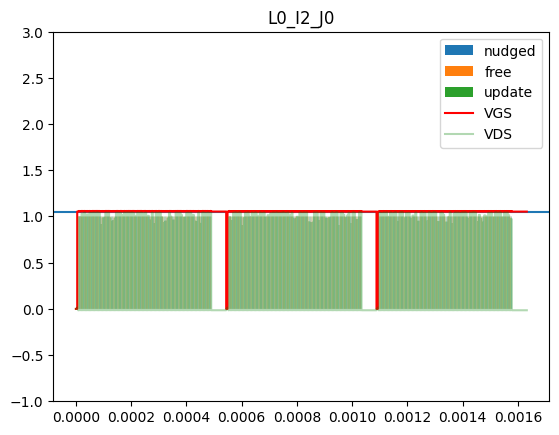

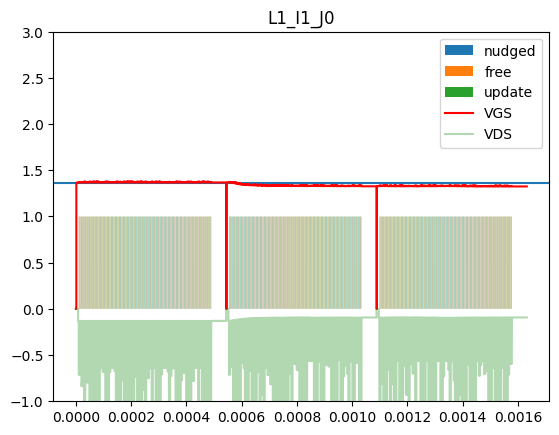

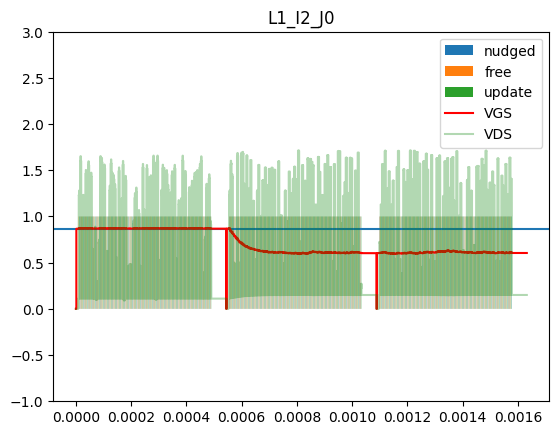

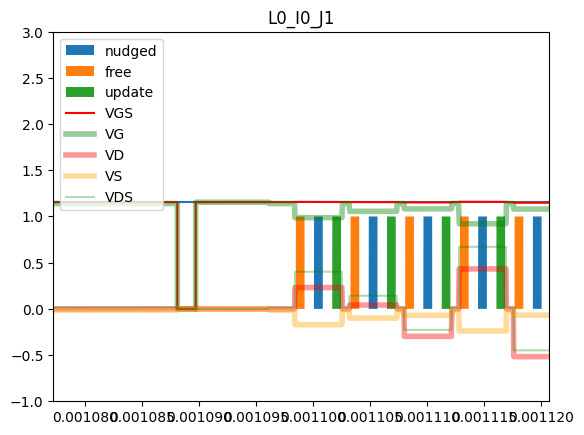

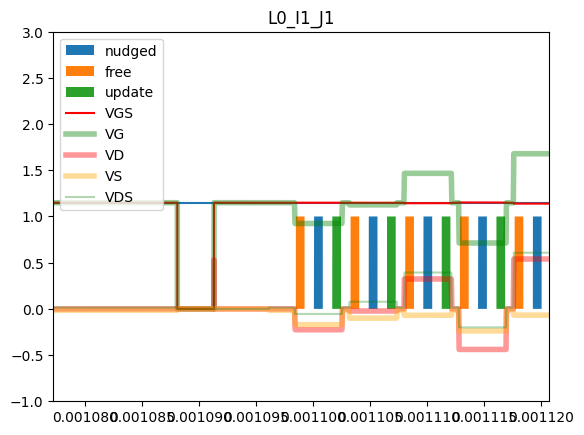

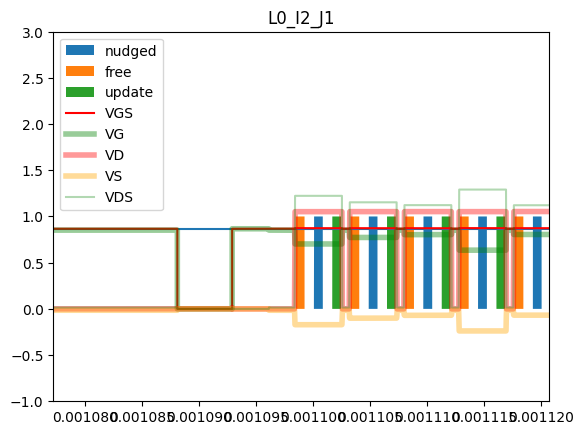

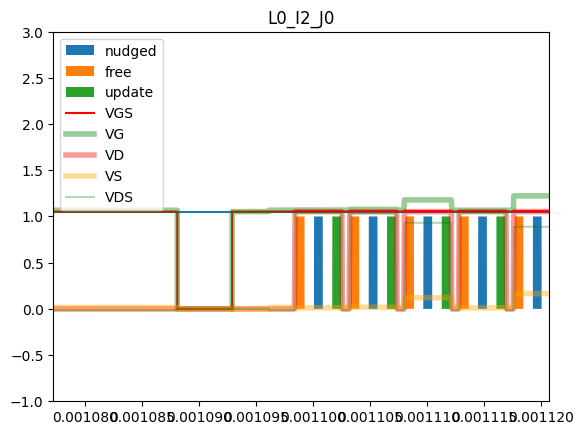

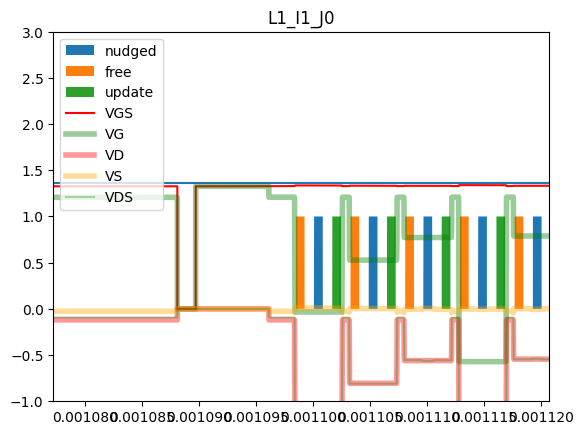

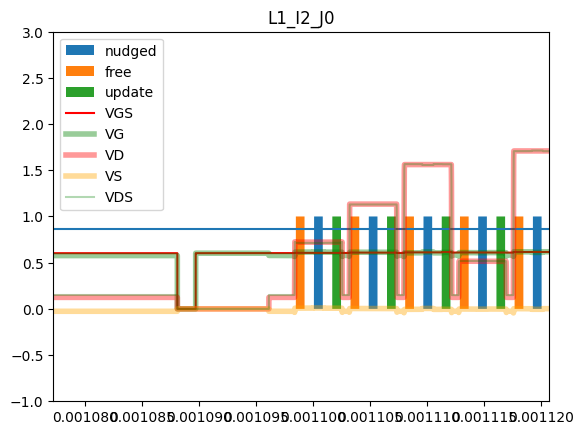

----- saving epoch 3:  50%|█████     | 3/6 [03:43<02:52, 57.44s/it] 

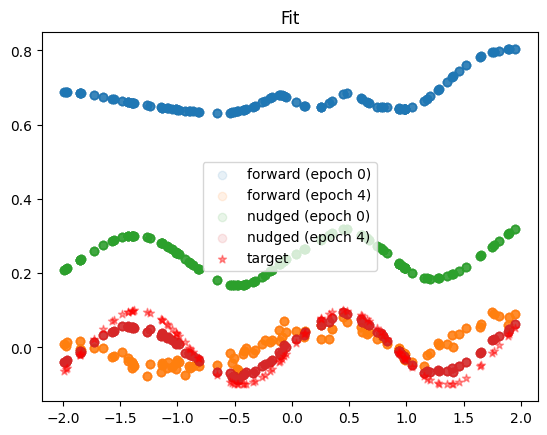

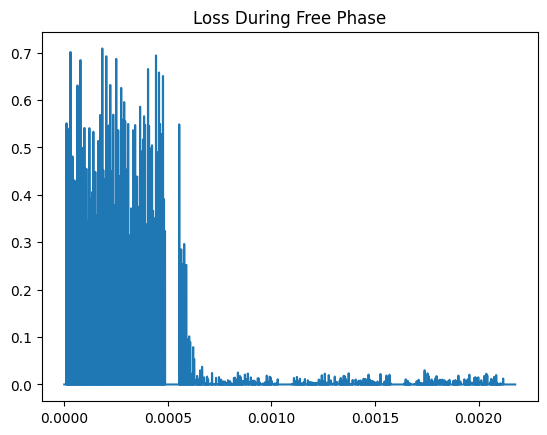

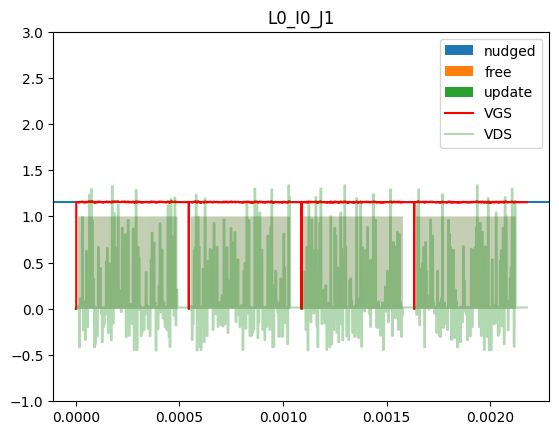

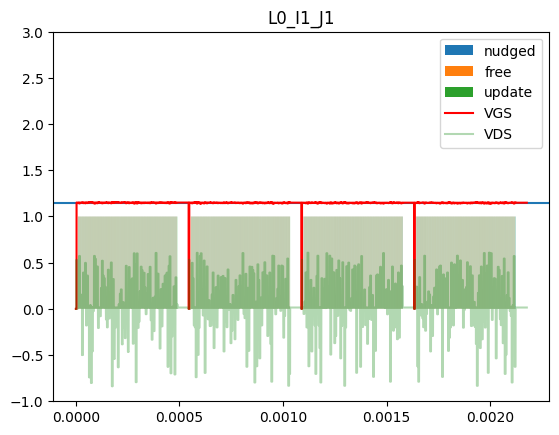

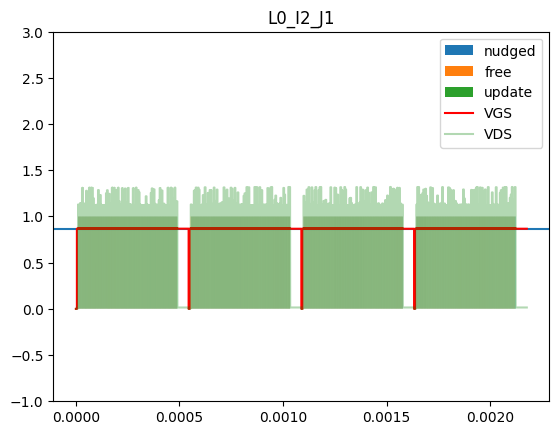

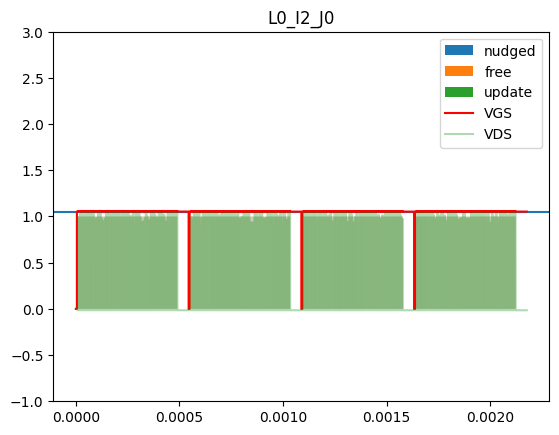

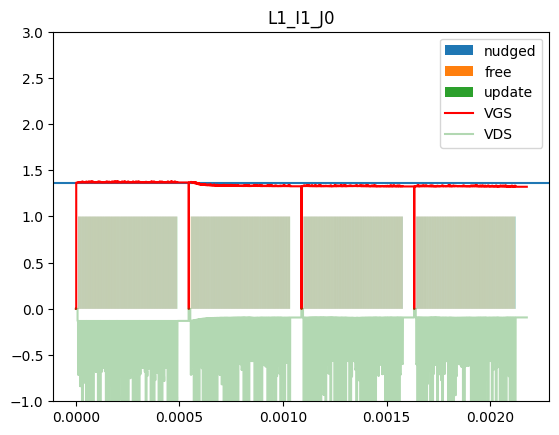

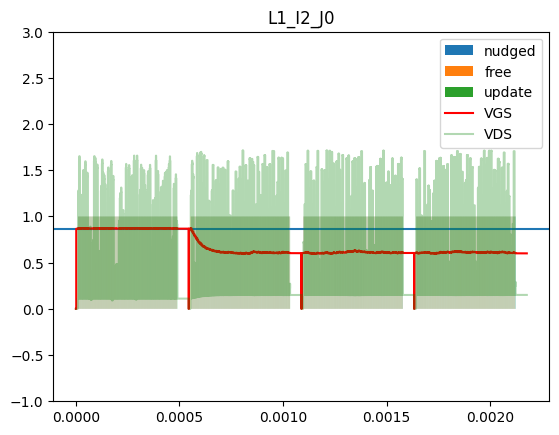

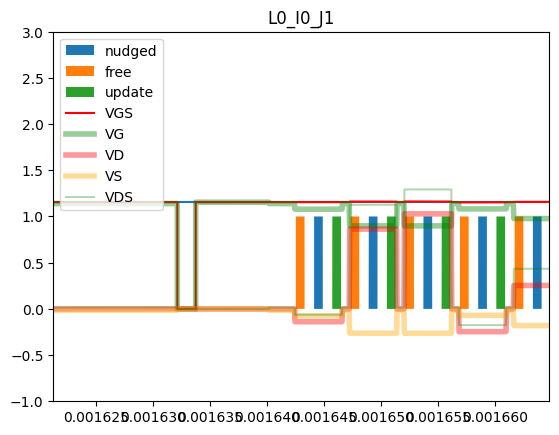

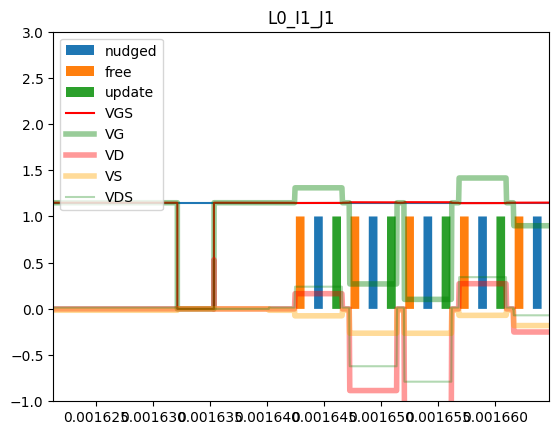

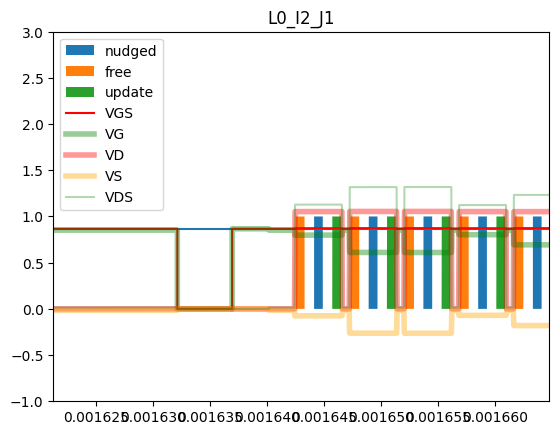

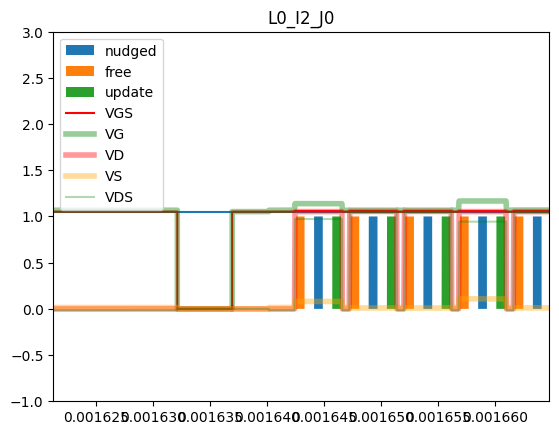

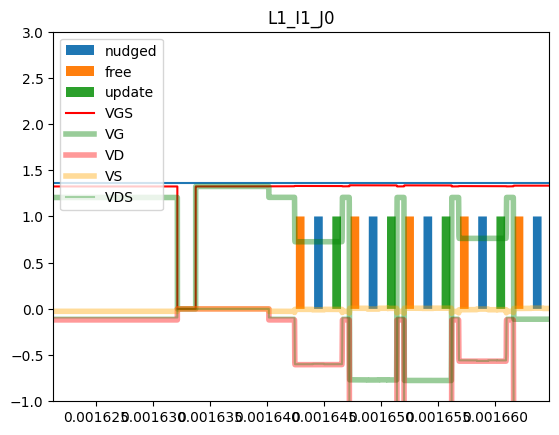

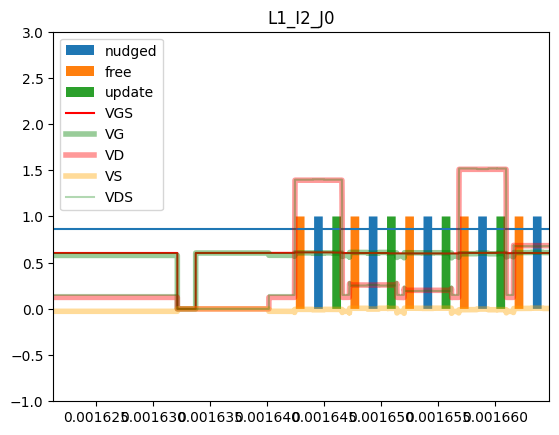

----- saving epoch 4:  67%|██████▋   | 4/6 [04:46<02:01, 60.56s/it] 

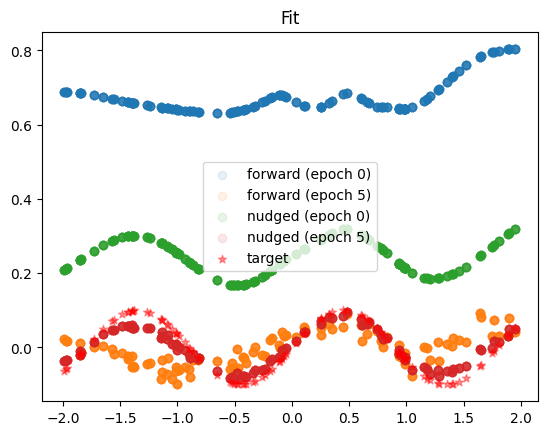

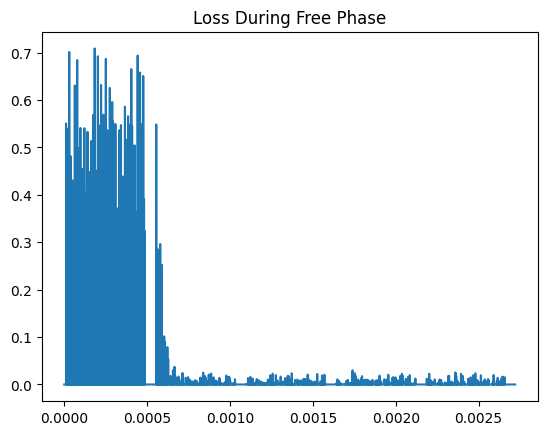

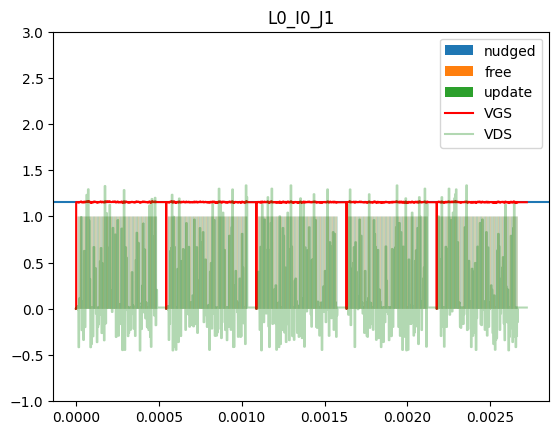

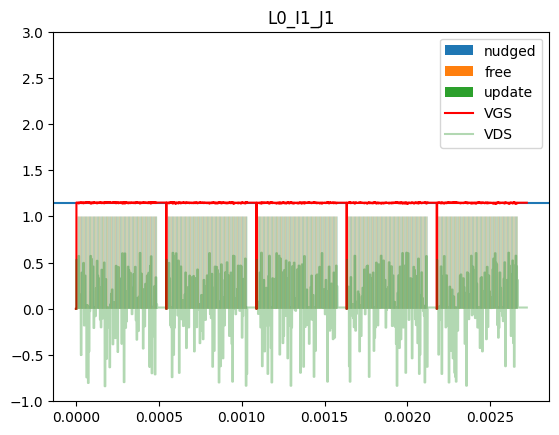

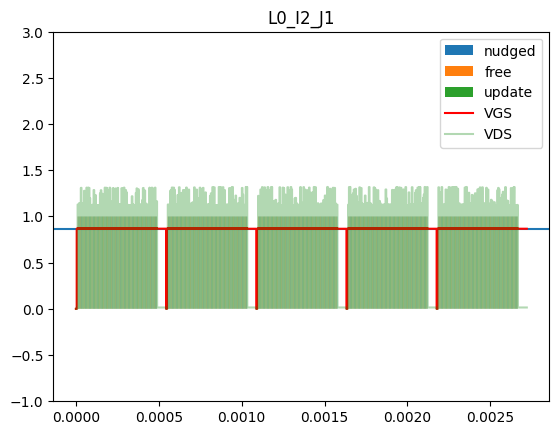

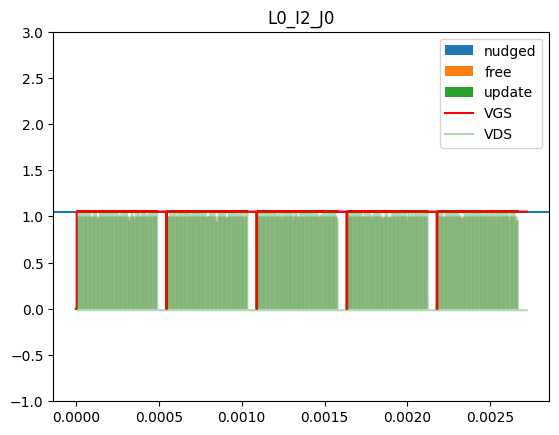

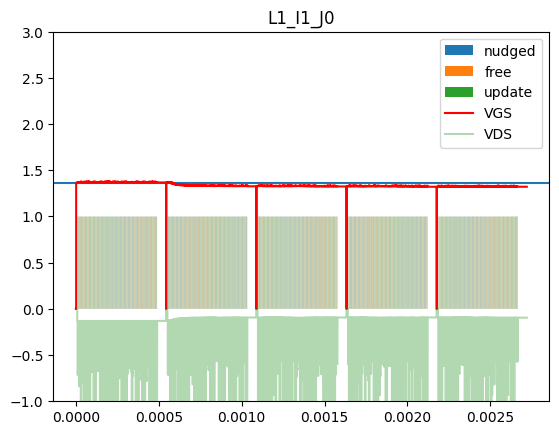

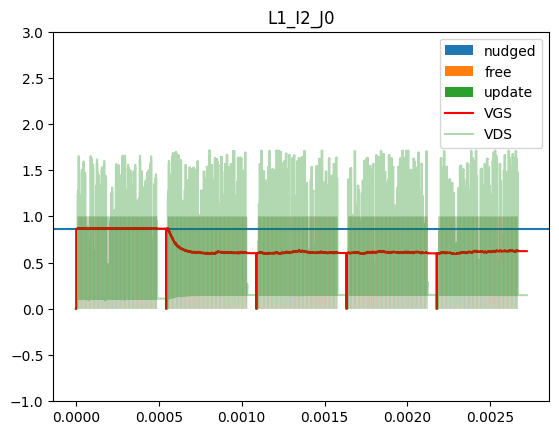

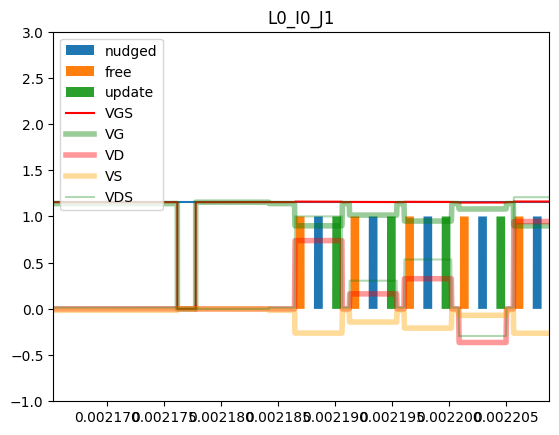

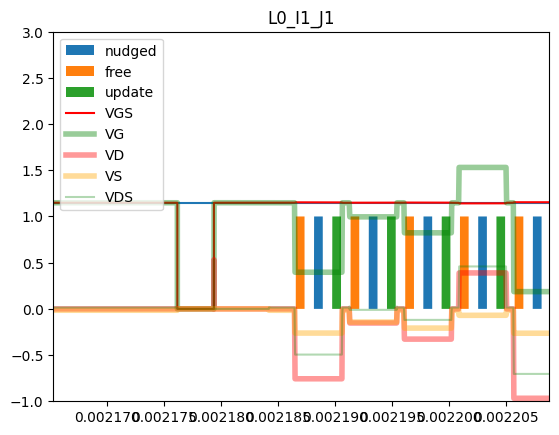

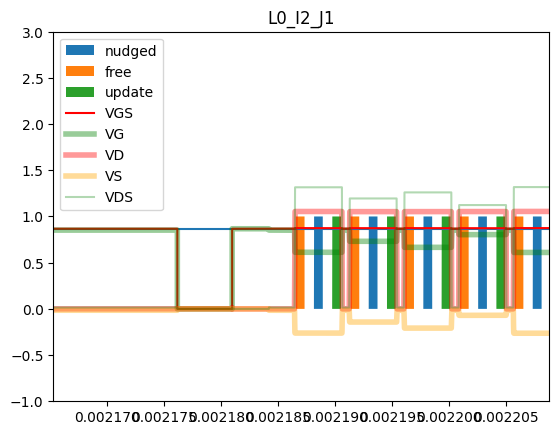

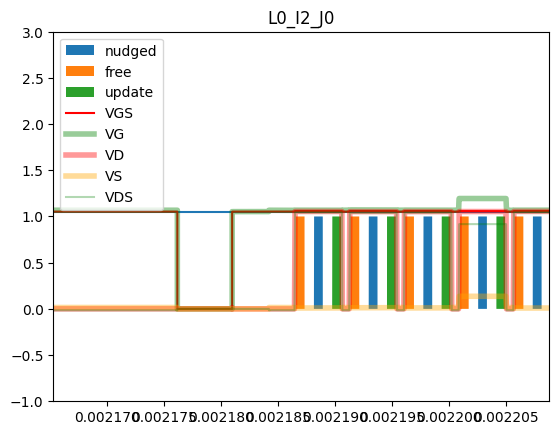

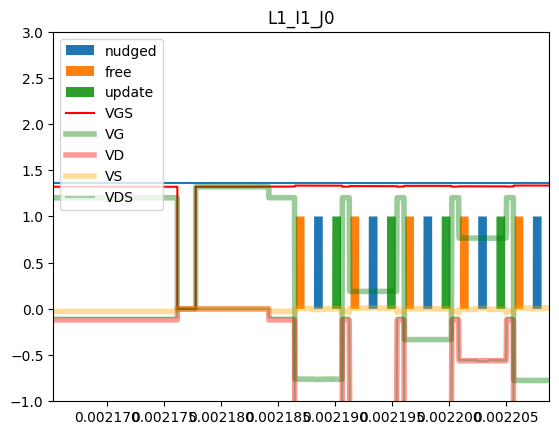

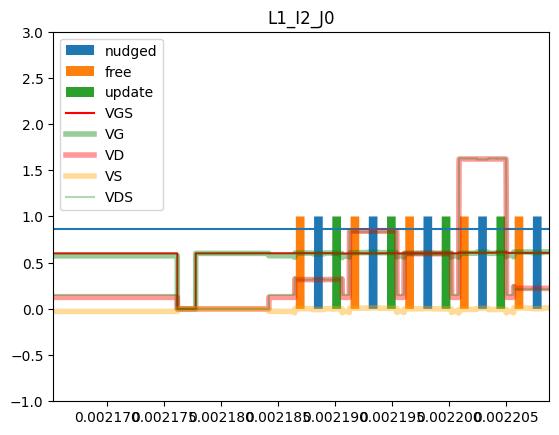

----- running epoch 5:  83%|████████▎ | 5/6 [04:53<01:02, 62.12s/it]

not updating weights in first and last epoch


----- saving epoch 5:  83%|████████▎ | 5/6 [05:26<01:02, 62.12s/it] 

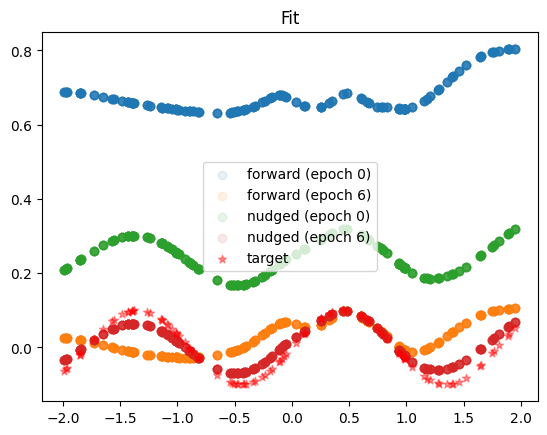

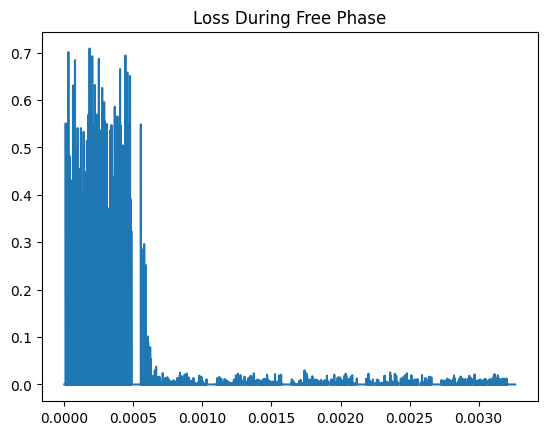

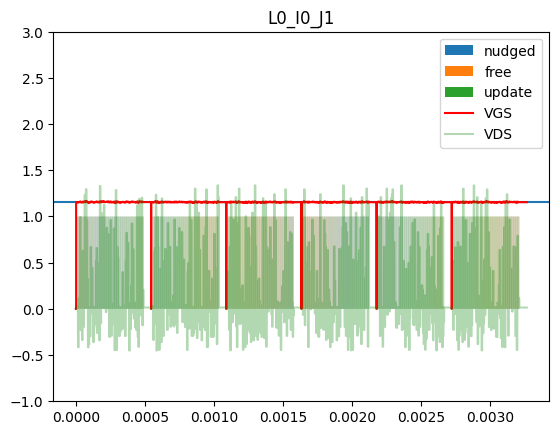

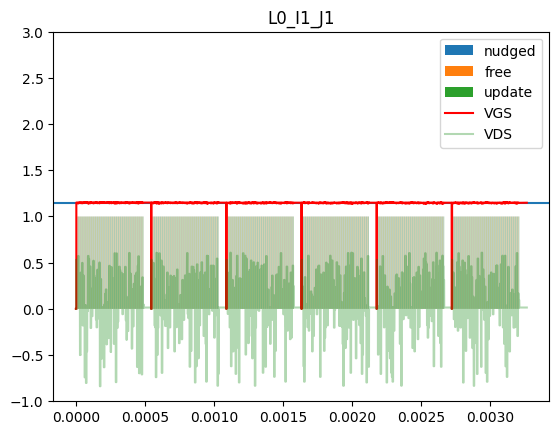

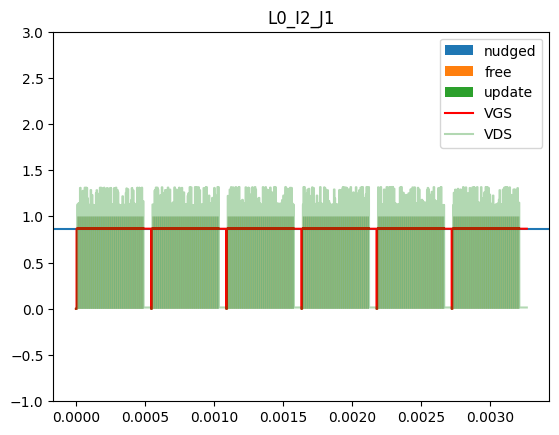

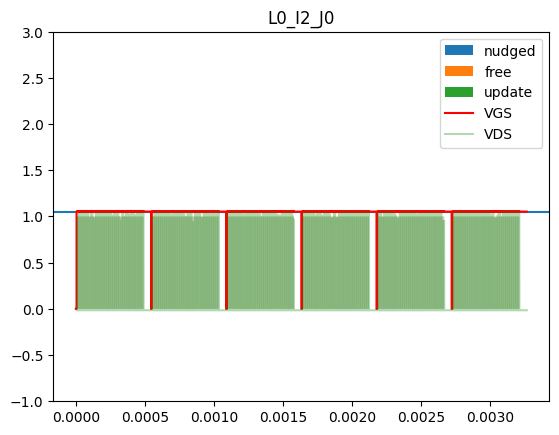

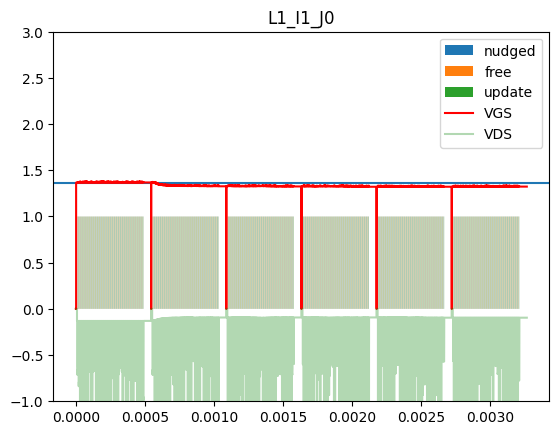

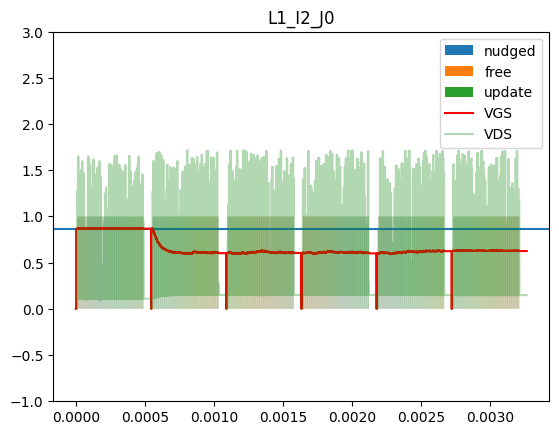

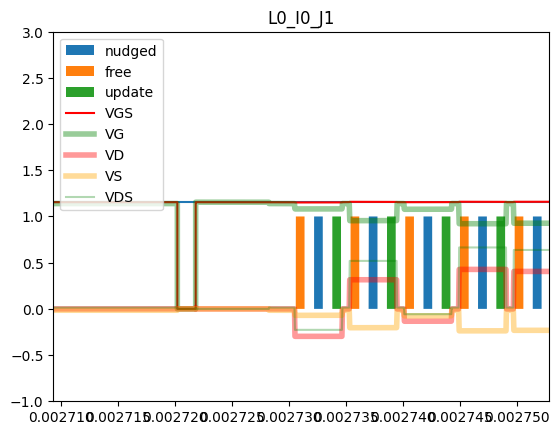

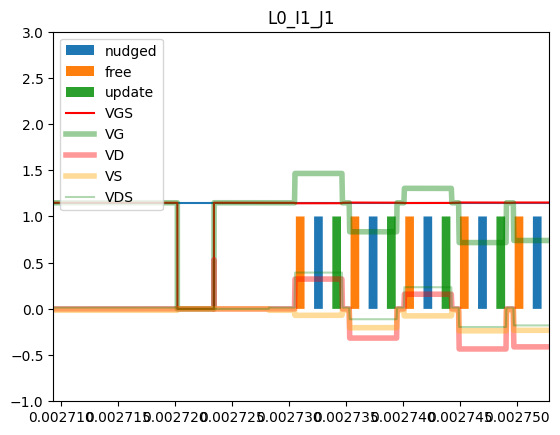

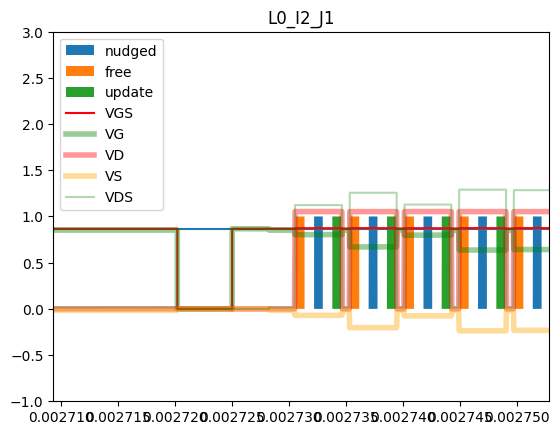

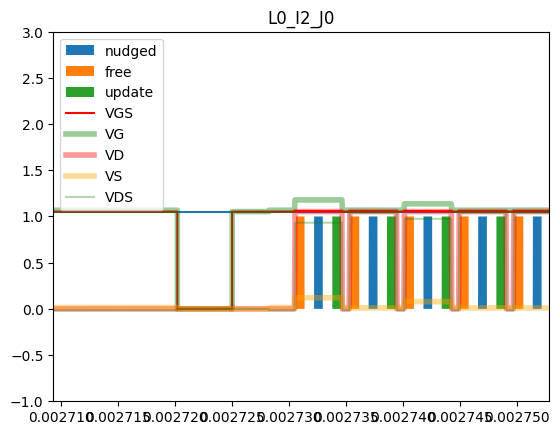

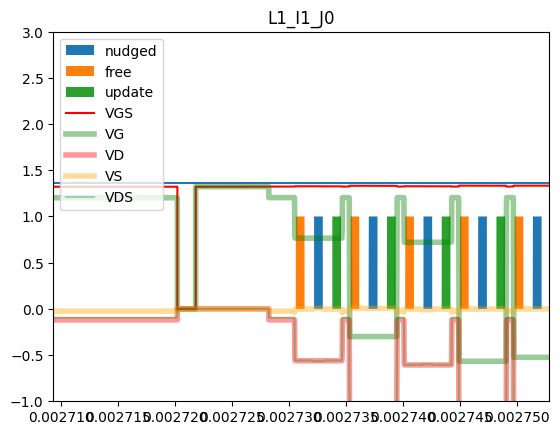

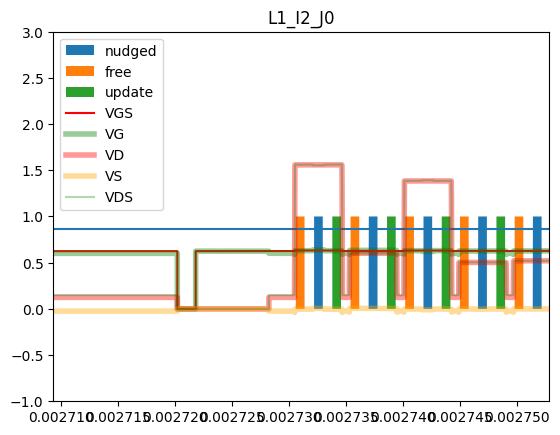

----- saving epoch 5: 100%|██████████| 6/6 [05:34<00:00, 55.75s/it]

done


In [1]:
!rm -rf /var/tmp
!rm -rf /tmp/*
!rm -rf ./tmp*
import time
time.sleep(2)
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory, DeviceModel
from PySpice.Unit import u_V, u_mV, u_ps, u_ns, u_us, u_ms, u_Ohm, u_kOhm, u_uF, u_uA, u_pF, u_A, u_s
import matplotlib.pyplot as plt
import torch
from torch import nn
import os, warnings, tqdm, logging
import numpy as np

# Synapse: performing a nonlinear analog "multiplication" between weights (MEM) and currents (RIN)
class Synapse(SubCircuitFactory):
    def __init__(self, cap, symmetrize=False):
        self.NAME = 'synapse'
        self.NODES = ('WWL', 'WBL', 'RIN', 'ROUT', 'REF')
        super().__init__()
        
        self.S('write_nfet', 'MEM', 'WBL', 'WWL', self.gnd, model='switch')
        #self.X('write_nfet', 'sky130_fd_pr__nfet_01v8', 'WBL', 'WWL', 'MEM', '0', l=0.15, w=1.0)
        self.C('cap', 'MEM', 'REF', cap, model='capacitor')
        if not symmetrize:
            self.X('read_nfet', 'sky130_fd_pr__nfet_01v8', 'RIN2', 'MEM', 'ROUT', 'REF', l=0.15, w=1.0)
        else:
            self.X('read_nfet1', 'sky130_fd_pr__nfet_01v8', 'RIN2', 'MEM', 'REF', 'REF', l=0.15, w=1.0)
            self.X('read_nfet2', 'sky130_fd_pr__nfet_01v8', 'REF', 'MEM', 'ROUT', 'REF', l=0.15, w=1.0)
        self.R('sourcedegenerate', 'RIN', 'RIN2', 100@u_Ohm)
        self.R('shortcut', 'RIN', 'ROUT', 10000@u_Ohm)

# Amplifier: a (linear) activation function between layers, amplifying voltages forward and currents backward
class Amplifier(SubCircuitFactory):
    def __init__(self, name, v_gain, i_gain, shift, lower=None, upper=None, Vth=0.75):
        self.NAME = name
        self.NODES = ('IN', 'OUT')
        super().__init__()
        if (v_gain is not None) and (i_gain is not None):
            self.B('vcvs', 'OUT', self.gnd, voltage_expression=f'{{{v_gain} * V(IN)}}')
            #self.B('vcvs', 'OUT', self.gnd, voltage_expression=f'{{{v_gain} * min(max(V(IN), {lower if lower is not None else -10}), {upper if upper is not None else 10})}}')
            self.B('cccs', 'INN', self.gnd, current_expression=f'{{{-i_gain} * I(Bvcvs)}}') #{{{-1/gain} * I(Bvcvs)}}
        else:
            self.R("short", "INN", "OUT", 0.0@u_Ohm) # shorting, should be equivalent to gain=1
        self.R("meas", "IN", "INN", 0.001@u_Ohm)
        #self.R('inn', 'OUT', 'OUTT', 0.001@u_Ohm)
        if lower is not None:
            #self.B('diol', 'OUTT', self.gnd, voltage_expression=f'{{max(V(IN), {lower})}}')
            self.V('diol', 'DIOL', '0', (lower+Vth)@u_V)
            self.D('diol', 'DIOL', 'OUT', model='diode')
        if upper is not None:
            #self.B('diou', 'OUTT', self.gnd, voltage_expression=f'{{min(V(IN), {upper})}}')
            self.V('diou', 'DIOU', '0', (upper-Vth)@u_V)
            self.D('diou', 'OUT', 'DIOU', model='diode')


# Optimizer: measures Vg during NUDGED phase, clamps it during FREE phase
class Optimizer(SubCircuitFactory):
    def __init__(self, cap, lower=0.6, upper=1.9):
        self.NAME = 'optimizer'
        self.NODES = ['WBL', 'FREE', 'NUDGED', 'NUDGED_OUTER', 'NUDGED_EARLY', 'UPDATE', 'REF', 'ANTIREF']
        super().__init__()

        self.B('opamp', 'OUT', self.gnd, voltage_expression=f'{{min(max(V(WBL), V(REF)+{lower}),V(REF)+{upper})*V(NUDGED_OUTER)/1.95}}')
        #self.S('storefree',    '0', 'STORE',   'FREE', self.gnd, model='switch') # reset during free phase (not strictly necessary)
        self.S('storenudge', 'OUT', 'STORE', 'NUDGED_EARLY', self.gnd, model='switch') # set to target value during nudged phase
        self.S('storeupdate','RES', 'STORE', 'UPDATE', self.gnd, model='switch') # apply update to WBL
        self.R('res', "RES", "WBL", 100@u_Ohm)
        self.C('store', 'STORE', '0', cap, model='capacitor')
        #self.C('store1', 'STORE', 'ANTIREF', cap, model='capacitor')


class Crossbar(SubCircuitFactory):
    def __init__(self, name, W, row_to_update, opt_cap, alternate_ref=False, t=False, max_rows=8, t_period=1600@u_ns, t_change=40@u_ns, t_offset=160@u_ns):
        self.NAME = name
        self.NODES = ["FREE", "NUDGED", "NUDGED_OUTER", "NUDGED_EARLY", "UPDATE"]
        self.NODES += [f"RIN_{i}" for i in range(W.shape[0])] + [f"ROUT_{j}" for j in range(W.shape[1])]
        super().__init__()
        #self.subcircuit(Optimizer(cap=opt_cap))
        rows, cols = W.T.shape if t else W.shape # weights in the same 'row' will be set/updated in parallel
        assert rows <= max_rows, f"max_rows={max_rows}<=rows={rows} assumption violated" # max_rows must be equal in all layers to sync timing
        
        # Setup Circuit
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                row, col = (j, i) if t else (i, j)
                self.X(f'W_I{i}_J{j}', 'synapse', f'WWL_{row}', f'WBL_{col}', f'RIN_{i}', f'ROUT_{j}', f'REF_I{i}_J{j}') # the synapse
                if alternate_ref:
                    self.R(f'ref_I{i}_J{j}', f'REF_I{i}_J{j}', f'RIN_{i}' if i%2==1 else f'ROUT_{j}', 0) # REF_i_j = the source (lower voltage side) of the read_nfet
                    self.R(f'antiref_I{i}_J{j}', f'ANTIREF_I{i}_J{j}', f'ROUT_{j}' if i%2==1 else f'RIN_{i}', 0) # ANTIREF_i_j = the drain (higher voltage side) of the read_nfet
                else:
                    self.R(f'antiref_I{i}_J{j}', f'ANTIREF_I{i}_J{j}', self.gnd, 0@u_Ohm)
                self.S(f'ref_I{i}_J{j}', f'REF_{col}', f'REF_I{i}_J{j}', f'WWL_{row}', self.gnd, model='switch') # forwards the right source to the optimizer
                self.S(f'antiref_I{i}_J{j}', f'ANTIREF_{col}', f'ANTIREF_I{i}_J{j}', f'WWL_{row}', self.gnd, model='switch') # forwards the right source to the optimizer
    
        for col in range(cols):
            self.X(f'opt_{col}', 'optimizer', f'WBL_{col}', 'FREE', 'NUDGED', 'NUDGED_OUTER', 'NUDGED_EARLY', 'UPDATE', f'REF_{col}', f'ANTIREF_{col}')
            #self.S(f'GND_{col}', f'REF_{col}', self.gnd, 'SET', self.gnd, model='switch') # ensures sources are grounded during weight setting
        for j in range(W.shape[1]):
            self.S(f'GND_{j}', f'ROUT_{j}', self.gnd, 'SET', self.gnd, model='switch') # ensures sources are grounded during weight setting

        # Set Weights: t_period = (t_change + t_width) * 2  = /---\___
        t_width = (t_period - 2 * t_change)/2
        wwl_times, wwl_values = [], []
        for row in range(rows):
            wwl_times.append([0@u_ns, t_period*(row+1), t_period*(row+1)+t_change,
                t_period*(row+1)+t_change+t_width, t_period*(row+1)+2*t_change+t_width])
            wwl_values.append([0@u_V, 0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V])
        
        for col in range(cols):
            times, values  = [0@u_ns], [0@u_V]
            for row in range(rows):
                    i, j  = (col, row) if t else (row, col)
                    times += [t_period*(row+1)-t_offset, t_period*(row+1)-t_offset+t_change,
                              t_period*(row+1)+t_offset+t_change+t_width, t_period*(row+1)+t_offset+2*t_change+t_width]
                    values += [0@u_V, W[i, j].item()@u_V, W[i, j].item()@u_V, 0@u_V]
            self.PieceWiseLinearVoltageSource(f'SET_{col}', f'SET_{col}', self.gnd, values=zip(times, values))
            self.S(f'SET_{col}', f'SET_{col}', f'WBL_{col}', 'SET', self.gnd, model='switch')

        times  = [0@u_ns, (max_rows+1) * t_period, (max_rows+1) * t_period + t_change]
        self.PieceWiseLinearVoltageSource(f'SET', f'SET', self.gnd, values=zip(times, [1.95@u_V, 1.95@u_V, 0@u_V]))

        # Update Weights
        for row in range(rows):
            wwl_values[row] += [0@u_V]
            wwl_times[row]  += [(max_rows+2) * t_period]
            for i, update in enumerate(row_to_update):
                for p, phase in enumerate(['FREE', 'NUDGED', 'UPDATE']):
                    start = (max_rows+2 + i*3 + p) * t_period + t_width
                    startoff, endoff = (+t_offset, -t_offset) if phase=='UPDATE' else (-t_offset, +t_offset)
                    wwl_times[row]  += [start+startoff, start+t_change+startoff, start+t_width+t_change+endoff, start+t_width+t_change*2+endoff]
                wwl_values[row] += [0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V] * 3 if row == update else [0@u_V]*12
            self.PieceWiseLinearVoltageSource(f'WWL_{row}', f'WWL_{row}', '0', values=zip(wwl_times[row], wwl_values[row]))


class MSELoss(SubCircuitFactory):
    def __init__(self, dY, lr, cap):
        self.NAME = 'loss'
        self.NODES  = ['FREE', 'NUDGED']
        self.NODES += [f"Y_{i}"  for i in range(dY)] + [f"PRED_{i}" for i in range(dY)]
        super().__init__()
        LOSS = ""
        for i in range(dY):
            self.S(f'PRED_{i}_NUDGED', f'PRED_{i}', f'PRED_{i}_NUDGED', 'NUDGED', self.gnd, model='switch')
            self.S(f'PRED_{i}_FREE', f'PRED_{i}', f'PRED_{i}_FREE', 'FREE', self.gnd, model='switch')
            self.C(f'PRED_{i}_FREE', f'PRED_{i}_FREE', self.gnd, cap, model='capacitor')
            #self.B(f"NUDGE_{i}", f"PRED_{i}_NUDGED", self.gnd, current_expression=f"{{-{lr} * (V(Y_{i})-V(PRED_{i}_FREE)) * V(NUDGED)}}")
            #self.B(f"NUDGE_{i}", f"PRED_{i}_NUDGED", self.gnd, voltage_expression=f"{{V(PRED_{i}_FREE) + {lr} * (V(Y_{i})-V(PRED_{i}_FREE))}}")
            self.B(f"NUDGE_{i}", f"NUDGE_{i}", self.gnd, voltage_expression=f"{{V(Y_{i})}}")
            self.R(f"NUDGE_{i}", f"PRED_{i}_NUDGED", f"NUDGE_{i}", 50@u_Ohm)
            LOSS += f"+ ( V(Y_{i}) - V(PRED_{i}) )**2"
        self.B("LOSS", "LOSS", self.gnd, voltage_expression=f"{{{LOSS[1:]}}}")


class MLP(SubCircuitFactory):
    def __init__(self, weights, X, Y, rows_to_update, lr, v_gain, i_gain, shift, cap=0.05@u_pF, t_period=1600@u_ns, t_change=40@u_ns, t_offset=80@u_ns, alternate=True, max_act=0.5):
        self.NAME   = 'mlp' 
        self.NODES = ['NUDGED', 'FREE', 'UPDATE']
        self.NODES += [f'X_{i}' for i in range(dims[0])]
        self.NODES += [f'Y_{j}_{phase}' for j in range(dims[-1]) for phase in ["NUDGED"]]
        super().__init__()
        self.model('switch',  'VSWITCH', VON=0.5@u_V, VOFF=0.4@u_V, ROFF=1e11@u_kOhm, RON=0.0001@u_Ohm)
        self.model('diode', 'D')
        self.model('capacitor', 'C')
        self.subcircuit(Synapse(cap=cap, symmetrize=not alternate))
        self.subcircuit(Amplifier('amp_lin', v_gain, i_gain, shift,))
        self.subcircuit(Amplifier('amp_pos', v_gain, i_gain, shift, lower=0., upper=max_act))
        self.subcircuit(Amplifier('amp_neg', v_gain, i_gain, shift, upper=0., lower=-max_act if max_act is not None else None))
        self.subcircuit(Optimizer(cap=cap))

        max_rows = max(min(W.shape) for W in weights)
        for L, (W, row_to_update) in enumerate(zip(weights, rows_to_update.T)):
            scale = [1000, 10][L]       # scales updates in earlier layers
            t = (W.shape[0]>W.shape[1])  # maximizes how many weights can be updated at once by transposing crossbar update circuit
            self.subcircuit(Crossbar(f'crossbar_L{L}', W, row_to_update, cap*scale, alternate, t, max_rows, t_period, t_change, t_offset))
        self.subcircuit(MSELoss(Y.shape[1], lr, cap))

        
        for L, (i, o) in enumerate(zip((X.repeat(0,2), *weights), (*weights, Y.T))):
            assert i.shape[1] == o.shape[0], f'shape mismatch {i.shape[1]}!={o.shape[1]} in layer {L}, check tensor shapes'
        
        for L, W in enumerate(weights):
            self.X(f'layer_L{L}', f'crossbar_L{L}', 'FREE', 'NUDGED', 'NUDGED_OUTER', 'NUDGED_EARLY', 'UPDATE',
                *(f'postact_L{L}_I{i}' for i in range(W.shape[0])),
                *(f'preact_L{L+1}_I{i}' for i in range(W.shape[1]))
            )

            for i in range(W.shape[1]):
                nonlinearity = 'amp_pos' if i%2==0 else 'amp_neg'
                act = 'amp_lin' if (L==len(weights)-1) else nonlinearity #and (i<Y.shape[1])) else nonlinearity
                self.X(f'act_L{L+1}_I{i}', act, f'preact_L{L+1}_I{i}', f'postact_L{L+1}_I{i}')

        self.X('loss', 'loss', 'FREE', 'NUDGED_OUTER',
                *(f'Y_{i}' for i in range(Y.shape[1])),
                *(f'postact_L{L+1}_I{i}' for i in range(W.shape[1]))
        )

        ## Feed data for training
        times = [0@u_ns, (max_rows+2) * t_period]
        times_outer  = [0@u_ns, (max_rows+2) * t_period]
        times_early  = [0@u_ns, (max_rows+2) * t_period]
        t_width = (t_period - 2 * t_change)/2
        xvalues = [[0@u_V, 0@u_V,] for i in range(X.shape[1])]
        yvalues = [[0@u_V, 0@u_V] for i in range(Y.shape[1])]
        nudged  = [0@u_V, 0@u_V,]
        free    = [0@u_V, 0@u_V,]
        update  = [0@u_V, 0@u_V,]
        for i in range(X.shape[0]):
            for phase in ('FREE', 'NUDGED', 'UPDATE'):
                times += [times[-1]+t_width, times[-1]+t_width+t_change, times[-1]+2*t_width+t_change, times[-1]+2*t_width+2*t_change]
                times_outer += [times[-4]-t_offset, times[-3]-t_offset, times[-2]+t_offset, times[-1]+t_offset]
                times_early += [times[-4]-t_offset, times[-3]-t_offset, times[-2]-t_offset, times[-1]-t_offset]
            free   += [0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V] # ___|--|_____________ FREE
            nudged += [0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V] # ________|--|________ NUDGED
            update += [0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V] # _____________|--|___ UPDATE
            for d in range(X.shape[1]):                                                                          # __|---------------|_________ X
                xvalues[d] += ([0@u_V] + [X[i,d].item()@u_V] * 10 + [0@u_V])
            for d in range(Y.shape[1]):
                yvalues[d] += ([0@u_V] + [Y[i,d].item()@u_V] * 10 + [0@u_V])
        
        self.PieceWiseLinearVoltageSource(f'FREE', 'FREE', '0', values=zip(times, free))
        self.PieceWiseLinearVoltageSource(f'NUDGED', 'NUDGED', '0', values=zip(times, nudged))
        self.PieceWiseLinearVoltageSource(f'NUDGED_OUTER', 'NUDGED_OUTER', '0', values=zip(times_outer, nudged))
        self.PieceWiseLinearVoltageSource(f'NUDGED_EARLY', 'NUDGED_EARLY', '0', values=zip(times_early, nudged))
        self.PieceWiseLinearVoltageSource(f'UPDATE', 'UPDATE', '0', values=zip(times, update))

        for i in range(X.shape[1]):
            self.PieceWiseLinearVoltageSource(f'Xp_{i}', f'Xp_{i}', '0', values=zip(times_outer, xvalues[i]))
            self.PieceWiseLinearVoltageSource(f'Xn_{i}', '0', f'Xn_{i}', values=zip(times_outer, xvalues[i]))
            self.R(f'Xp_{i}', f'postact_L0_I{2*i}', f'Xp_{i}', 100@u_Ohm)
            self.R(f'Xn_{i}', f'postact_L0_I{2*i+1}', f'Xn_{i}', 100@u_Ohm)
            self.R(f'Xpg_{i}', f'Xp_{i}', '0', 1000@u_Ohm)
            self.R(f'Xng_{i}', f'Xn_{i}', '0', 1000@u_Ohm)
        for i in range(Y.shape[1]):
            self.PieceWiseLinearVoltageSource(f'Y_{i}', f'Y_{i}', '0', values=zip(times_outer, yvalues[i]))
        self.duration = max(times_outer) * 1.1



def plot_analyses(analyses):
    analysis = dict()
    epoch_times = []
    for node in analyses[0].nodes:
        analysis[node] = np.array(analyses[0][node])
    epoch_times.append(0)
    for a in analyses[1:]:
        for node in a.nodes:
            if node == "time":
                epoch_times.append(analysis[node].max().item())
                analysis[node] = np.concatenate([analysis[node], analysis[node].max()+np.array(a[node])])
            else:
                analysis[node] = np.concatenate([analysis[node], np.array(a[node])])
    epoch_times.append(analysis["time"].max().item())

    x0 = np.array(analysis["XMLP:XP_0"])
    y  = np.array(analysis["XMLP:POSTACT_L2_I0"])
    nudged = np.array(analysis["NUDGED"])
    free = np.array(analysis["FREE"])
    update = np.array(analysis["UPDATE"])
    loss   = np.array(analysis["XMLP:XLOSS:LOSS"])
    time   = np.array(analysis["time"])
    during_nudged = np.abs(nudged - nudged.max()) < 1e-2
    during_free = np.abs(free-free.max()) < 1e-2
    during_update = np.abs(update-update.max()) < 1e-2
    late = time > epoch_times[-2]
    early = (time < epoch_times[1])

    plt.title("Fit")
    for phase, select in [
            (f"forward (epoch 0)", during_free & early),
            (f"forward (epoch {len(epoch_times)-1})", during_free & late),
            (f"nudged (epoch 0)", during_nudged & early),
            (f"nudged (epoch {len(epoch_times)-1})", during_nudged & late), 
        ]:
        plt.scatter(x0[select], y[select], alpha=0.1, label=phase)
    plt.scatter(X[:,0], Y[:,0], color="red", alpha=0.4, label="target", marker='*')
    plt.legend()
    plt.savefig("fig_sine_11.png")
    plt.show()
    plt.plot(time, loss*during_free)
    plt.title("Loss During Free Phase")
    plt.show()

    for full_length in [True, False]:
        for l, i, j in [(0,0,1), (0,1,1), (0,2,1),  (0,2,0),  (1,1,0), (1,2,0)]:
            ROUT = np.array(analysis[f"XMLP:PREACT_L{l+1}_I{j}"])
            RIN = np.array(analysis[f"XMLP:POSTACT_L{l}_I{i}"])
            Vg = np.array(analysis[f"XMLP:XLAYER_L{l}:XW_I{i}_J{j}:MEM"])
            REF = np.array(analysis[f"XMLP:XLAYER_L{l}:REF_I{i}_J{j}"])
            plt.axhline(initial_weights[l][i,j])
            plt.fill_between(time, y1=0, y2=during_nudged, label="nudged")
            plt.fill_between(time, y1=0, y2=during_free, label="free")
            plt.fill_between(time, y1=0, y2=during_update, label="update")
            #plt.plot(ROUT, label="ROUT")
            plt.plot(time, Vg-REF, label="VGS", color="red")
            ep = len(epoch_times)-2
            start, d = epoch_times[ep], (epoch_times[ep+1]-epoch_times[ep])
            if not full_length:
                plt.xlim(start - d/n * 2, start + d/n * 6)
                plt.plot(time, Vg, label="VG", color="green", alpha=0.4, linewidth=4)
                plt.plot(time, RIN, label="VD", color="red", alpha=0.4, linewidth=4)
                plt.plot(time, ROUT, label="VS", color="orange", alpha=0.4, linewidth=4)
                #plt.plot(time, ref, label="REF", color="purple", ls='--', linewidth=1)
            plt.plot(time, RIN-ROUT, label="VDS", color="green", alpha=0.3)
            plt.title(f"L{l}_I{i}_J{j}")
            plt.legend()
            plt.ylim(-1, 3)
            plt.show()

# initialize data
n = 100
X = (torch.rand(n, 2)-0.5)*2
X[:,1:2] = 1
#sort = X[:,0].argsort()
#X = X[sort]
Y = (X[:,0:1]*7).sin()*0.1 #+ 0.2

X *= 2.0

# initialize network parameters
dims = [X.shape[1]*2, 32, Y.shape[1]] # input, hidden, output (both X and Y are 1d, but computed as difference between two positive outputs)
if dims[1] < 128: print("small d_hidden, don't expect a good fit!")
##weights = [(torch.rand(d_in//2, d_out)*2-1).repeat_interleave(2,0).mul(1-2*(torch.arange(d_in)%2==1)[:,None]).relu()*1.3 + 0.6 for l, (d_in, d_out) in enumerate(zip(dims[:-1], dims[1:]))]

##weights = [nn.Linear(d_in//2, d_out).weight.data.clone().repeat(2,1) for d_in, d_out in zip(dims[:-1], dims[1:])]

##weights = [0.6+nn.Linear(d_in//2, d_out).weight.data.clone().repeat_interleave(2,1).T.mul(1-2*(torch.arange(d_in)%2==1)[:,None]).relu() for d_in, d_out in zip(dims[:-1], dims[1:])]

#weights = [torch.rand(d_in, d_out)*1.1 + 0.6 for l, (d_in, d_out) in enumerate(zip(dims[:-1], dims[1:]))]
weights = [torch.rand(d_in, d_out)*1 + 0.7 for l, (d_in, d_out) in enumerate(zip(dims[:-1], dims[1:]))]
initial_weights = [_.clone() for _ in weights]

# initialize training hyperparameters
epochs = 6#6#25#8
lr = 0.004 #0.05#1#10.10005
v_gain = 8 #0.2#4#4#2#2#0.1 #0.6# from 1 <<<<,
i_gain = 1/v_gain if v_gain is not None else None#5
shift = 0

# silence xyce warnings
logging.basicConfig(filename='pyspice_warnings.log', level=logging.WARNING, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
pyspice_logger = logging.getLogger('PySpice')
pyspice_logger.setLevel(logging.WARNING)


print(dims)
# simulate
analyses = []
try:
    for epoch in (progress := tqdm.tqdm(range(epochs))):
        # sample columns to free at each datapoint
        rows_to_update = torch.stack([torch.arange(min(i,o)).repeat(n//min(i,o)+1)[torch.randperm(min(i,o)*(n//min(i,o)+1))][:n] for i, o in zip(dims[:-1], dims[1:])]).T
        if not ((epoch > 0) & (epoch<epochs-1)): 
            print("not updating weights in first and last epoch")
            rows_to_update.fill_(-1)

        # shuffle data
        perm = torch.randperm(n)
        X, Y = X[perm], Y[perm]

        # run transient simulation of current epoch
        progress.set_description(f"--- preparing epoch {epoch}")
        circuit = Circuit('Crossbar Circuit')
        circuit.lib(f'/root/miniforge3/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice', 'tt')
        circuit.subcircuit(mlp := MLP(
            weights, X, Y, rows_to_update, lr, v_gain, i_gain, shift, alternate=True, max_act=None
        ))
        circuit.X('mlp', 'mlp', *mlp.NODES)
        simulator = circuit.simulator(simulator="xyce-parallel")
        progress.set_description(f"----- running epoch {epoch}")
        analysis = simulator.transient(step_time=20@u_ns, end_time=mlp.duration * 1.01)
        progress.set_description(f"----- saving epoch {epoch}")
        analyses.append(analysis)

        # set parameter variables to the most recent values
        time = np.array(analysis.time)
        for l in range(len(weights)):
            for i in range(weights[l].shape[0]):
                for j in range(weights[l].shape[1]):
                    weights[l][i, j] = (analysis[f"XMLP:XLAYER_L{l}:XW_I{i}_J{j}:MEM"] - analysis[f"XMLP:XLAYER_L{l}:REF_I{i}_J{j}"])[-10:].mean().item()
        
        plot_analyses(analyses)
except KeyboardInterrupt:
    print("Graceful Exit.")

print('done')